0.6%

/home/mamusiaarusia/praktyki/walidacja_funkcji.py:122: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  fsolve(lambda x: NKG_np(x, self.s.cpu().item(), self.r_m.cpu().item()) - epsilon, looking_x_left)[0],


100.0%

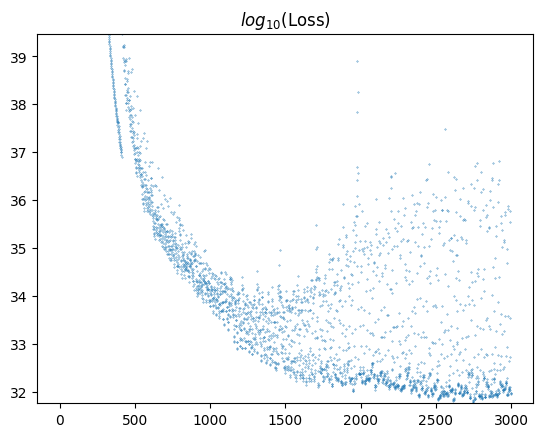

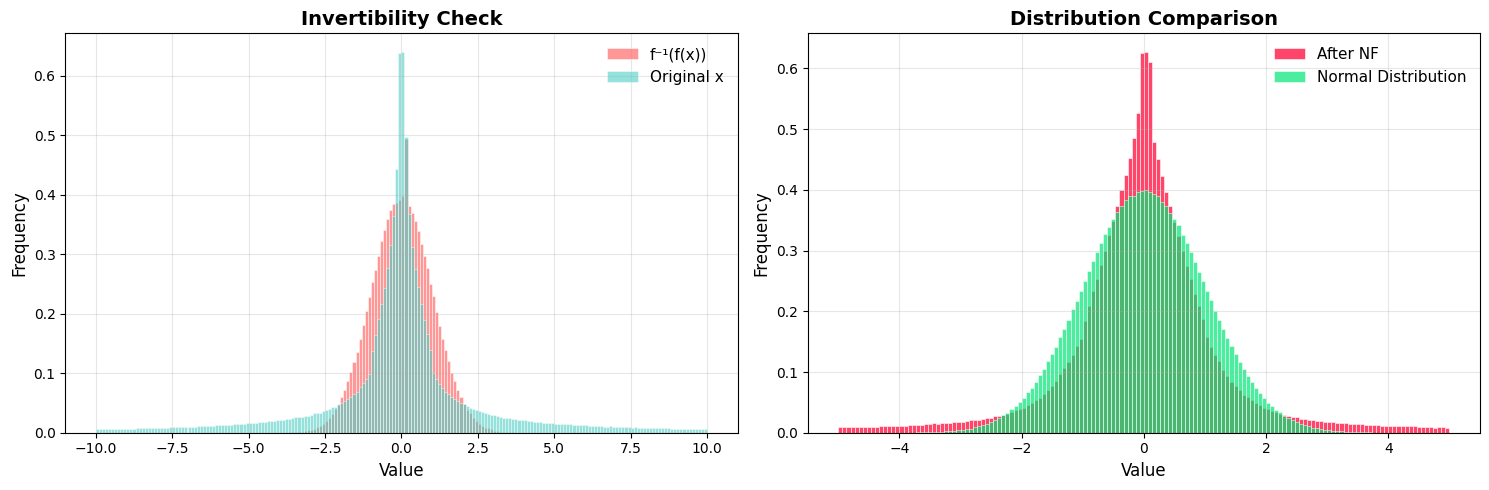

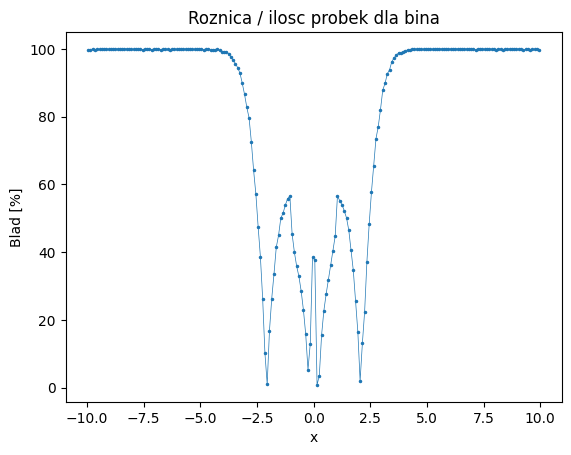

100.0%

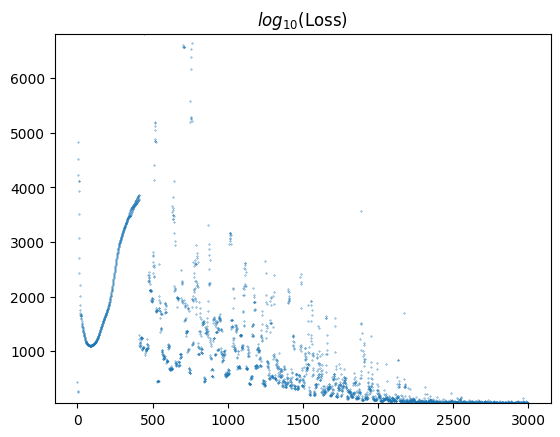

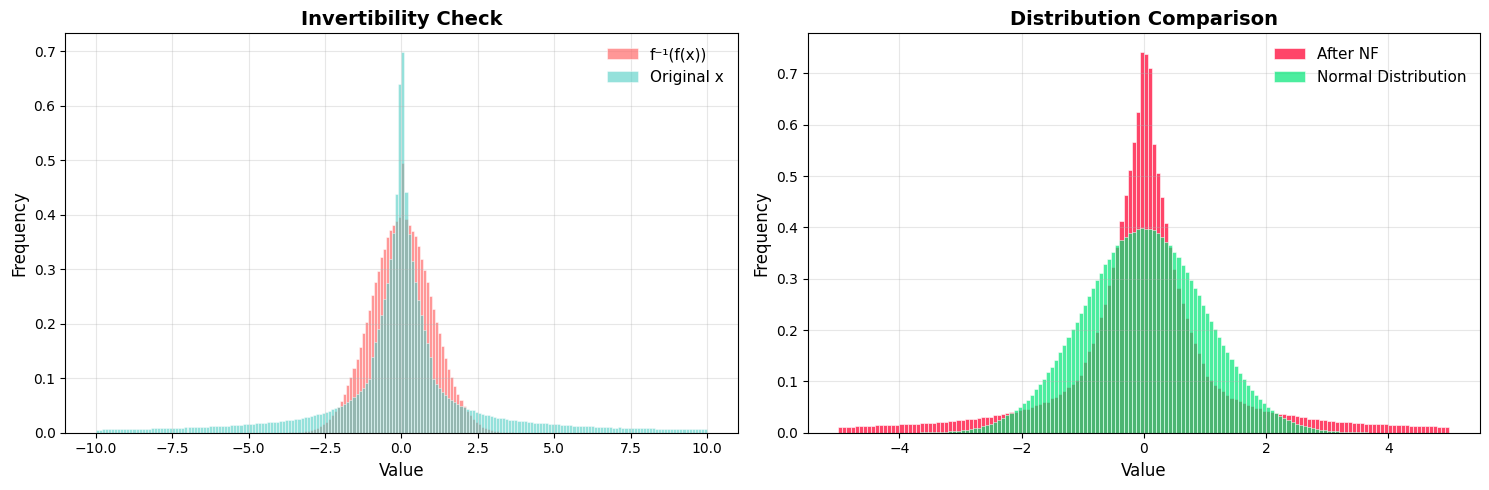

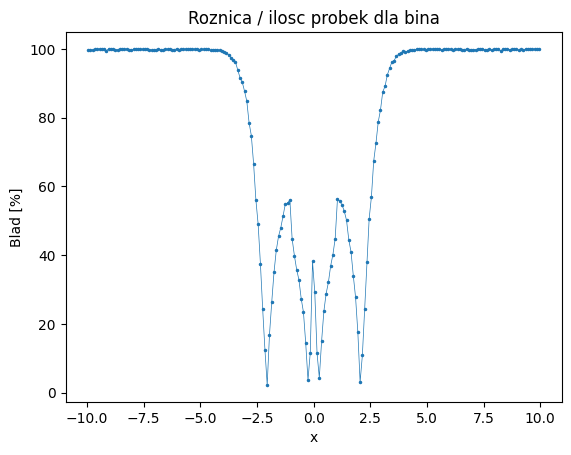

In [ ]:
# %%writefile nf.py
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import numpy as np
from walidacja_funkcji import *

sys.path.append('/home/mamusiaarusia/myenv/lib/python3.12/site-packages/torch')

prober = rs_prober_NKG(epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0, theta=None, alpha=None, phi=0.0)

def get_2d_data(PROBE_SIZE: int, prober=prober):
    rs = prober.rejection_sampling(length=PROBE_SIZE // 2)
    theta = torch.distributions.Uniform(low=0, high=2*torch.pi).sample((PROBE_SIZE // 2,))
    xs = rs * torch.cos(theta)
    ys = rs * torch.sin(theta)
    return torch.vstack([xs, ys]).T


def get_shower_data_with_angle(PROBE_SIZE, BATCH_SIZE, dim = np.array([0,1]), zero_angles = False):
    theta = 0.0 if zero_angles else np.random.uniform(low=0.0, high=np.radians(15))
    alpha = 0.0 if zero_angles else np.random.uniform(low=0.0, high=np.radians(70))
    angle_prober = rs_prober_NKG(epsilon=0.1, looking_x_left=-1, looking_x_right=10, from_x=0, theta=theta, alpha=alpha, phi=0.0)
    x = torch.Tensor(
        get_2d_data(PROBE_SIZE, angle_prober).view(BATCH_SIZE, -1, 2)[:, :, dim]
    ).cuda()
    angles = torch.Tensor([alpha, theta]).unsqueeze(0).cuda()
    if isinstance(dim, np.ndarray):
        x = torch.cat([x, angles.expand(BATCH_SIZE, 2, 2)], dim=1)
    else:
        x = torch.cat([x, angles.expand(BATCH_SIZE, 2)], dim=1)
    return x, angles


class MinMaxModule(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return (x - x.min()) / (x.max() - x.min())


class NF_layer(nn.Module):
    def __init__(self, translate_layers: list[nn.Module], scale_layers: list[nn.Module], lr):
        super().__init__()
        self.translate = nn.Sequential(*translate_layers)
        self.scale = nn.Sequential(*scale_layers)
        self.optim = torch.optim.RMSprop(self.parameters(), lr=lr) # tu nie jestem pewny moze dwa oddzielne optimizery powinny isc idk
        self.to('cuda')

    # mozna dodac loss_backward z funkcja probkowania z NKG
    def loss(self, output: torch.Tensor, log_diag: torch.Tensor = None):
        return 0.5 * (output ** 2).mean() - log_diag.mean() + torch.log(torch.Tensor([2 * torch.pi])).cuda()

    def loss_and_step(self, output: torch.Tensor, log_diag: torch.Tensor = None):
        self.zero_grad()
        loss = self.loss(output, log_diag)
        loss.backward()
        self.optim.step()
        return loss.item()

    def calculate_forward(self, input: torch.Tensor, function: callable) -> torch.Tensor:
        div_indx = input.shape[-1] // 2 - 1
        x1 = input[:, :div_indx]
        x2 = input[:, div_indx:]

        scaled = self.scale(x2)
        translated = self.translate(x2)

        x2 = function(x1, scaled, translated)
        z = torch.cat([x1, x2], dim=-1)

        return z, scaled, x2

    def forward(self, input: torch.Tensor, angles: torch.Tensor) -> torch.Tensor:
        return self.calculate_forward(input, lambda x2, scaled, translated: torch.cat([x2 * torch.exp(scaled) + translated, angles.expand(input.shape[0], 2)], dim=1))

    def inverse(self, input: torch.Tensor, angles: torch.Tensor) -> torch.Tensor:
        return self.calculate_forward(input, lambda x2, scaled, translated: torch.cat([(x2 - translated) / torch.exp(scaled), angles.expand(input.shape[0], 2)], dim=1))


class NF(nn.Module):
    def __init__(self, num_layers: int, input_size: int, lr: float, angle_size: int):
        super().__init__()
        input_size += angle_size

        def scaling_components(): # to nie musi byc funkcja
            return [ # kurde jak tu katy dolaczyc ? 
                nn.Linear(input_size, input_size), nn.Softsign(),
                nn.Linear(input_size, input_size), 
                nn.Linear(input_size, input_size), nn.Tanh(), 
                nn.Linear(input_size, input_size), 
                nn.Linear(input_size, input_size), 
                nn.Linear(input_size, input_size), 
                nn.Linear(input_size, input_size - angle_size), 
            ]

        def translating_components():
            return [
                nn.Linear(input_size, input_size - angle_size), # +2 bo katy
            ]

        self.layers = nn.ModuleList([NF_layer(translating_components(), scaling_components(), lr) for _ in range(num_layers)])
        self.to('cuda')

    def forward(self, x, angles: torch.Tensor):
        return self.iterate_layers(x, forward=True, learn=False, angles=angles)

    def inverse(self, x, angles: torch.Tensor):
        return self.iterate_layers(x, forward=False, learn=False, angles=angles)

    def loss_and_step(self, x, angles: torch.Tensor):
        return self.iterate_layers(x, forward=True, learn=True, angles=angles)

    def iterate_layers(self, input: torch.Tensor, forward: bool, learn: bool, angles: torch.Tensor):
        output = input.clone()
        transformed = None
        losses = 0

        iter_layers = self.layers if forward else reversed(self.layers)
        for layer in iter_layers:
            if forward:
                output, diag_sum, transformed = layer.forward(output, angles)
            else:
                output, diag_sum, transformed = layer.inverse(output, angles)

            if learn:
                losses += layer.loss_and_step(transformed, diag_sum)
                output = output.detach()

        if learn:
            return losses

        return output

# On ma kat zgadnac na koncu, na wyjsciu.

def learn_nf(nf_model: nn.Module, SAMPLES_TO_RETURN: int, BATCH_SIZE: int, EPOCHS: int, dim: int = 0):
    PROBE_SIZE = SAMPLES_TO_RETURN * BATCH_SIZE
    x, angles = get_shower_data_with_angle(PROBE_SIZE, BATCH_SIZE, dim)
    loss_history = np.empty(EPOCHS)

    nf_model.train()
    for epoch in range(EPOCHS):
        print(f'\r{epoch / (EPOCHS - 1) * 100:.1f}%', end='', flush=True)
        loss_history[epoch] = nf_model.loss_and_step(x, angles)
        if epoch % 10 == 0 and epoch > 400:
            x, angles = get_shower_data_with_angle(PROBE_SIZE, BATCH_SIZE, dim)

    nf_model.eval()

    plt.plot(loss_history, 'o', markersize=.3)
    plt.ylim([np.min(loss_history[400:]), np.sort(loss_history[400:])[-15]])
    plt.title(r'$log_{10}$(Loss)')
    plt.show()

    x, angles = get_shower_data_with_angle(PROBE_SIZE * 10, BATCH_SIZE * 10, dim)
    theory = np.random.randn(PROBE_SIZE * 10)
    to_inverse = torch.Tensor(theory).reshape(BATCH_SIZE * 10, SAMPLES_TO_RETURN // 2, 2).cuda()[:, :, dim]
    to_inverse = torch.cat([to_inverse, angles.expand(size=(to_inverse.shape[0], 2))], dim=1)

    values = nf_model.forward(x, angles)
    inversed = nf_model.inverse(to_inverse, angles).detach().flatten().cpu().numpy()
    values = values.detach().flatten().cpu().numpy()

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    colors = ['#FF6B6B', '#4ECDC4']
    
    inversed_bins, edges, _ = ax1.hist(inversed, bins=200, range=[-10, 10], label='f⁻¹(f(x))', 
            color=colors[0], alpha=0.7, edgecolor='white', linewidth=0.5, density=True)
    theory_bins, _, _ = ax1.hist(x.detach().flatten().cpu().numpy(), bins=200, range=[-10, 10], label='Original x', 
            color=colors[1], alpha=0.6, edgecolor='white', linewidth=0.5, density=True)
    ax1.set_title('Invertibility Check', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Value', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.legend(frameon=False, fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    ax2.hist(values, bins=150, range=[-5, 5], label='After NF',
            color='#FF1744', alpha=0.8, edgecolor='white', linewidth=0.5, density=True)
    ax2.hist(theory, bins=150, range=[-5, 5], label='Normal Distribution',
            color='#00E676', alpha=0.7, edgecolor='white', linewidth=0.5, density=True)
    ax2.set_title('Distribution Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Value', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.legend(frameon=False, fontsize=11)
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    avg_edges = (edges[1:] + edges[:-1]) / 2
    plt.title('Roznica / ilosc probek dla bina')
    plt.plot(avg_edges, np.clip(np.abs(inversed_bins - theory_bins) / (np.maximum(inversed_bins, theory_bins)) * 100, 0, 100), '-o', markersize=1.5, linewidth=0.5)
    plt.xlabel('x')
    plt.ylabel('Blad [%]')
    plt.show()

    return loss_history


SAMPLES_TO_RETURN = 768
DIMS = SAMPLES_TO_RETURN // 4
BATCH_SIZE = 512
EPOCHS = 3_000
LR = 1e-3
ANGLE_SIZE = 2

x_model = NF(8, DIMS, LR, ANGLE_SIZE)
x_loss = learn_nf(x_model, SAMPLES_TO_RETURN, BATCH_SIZE, EPOCHS, 0)

y_model = NF(8, DIMS, LR, ANGLE_SIZE)
y_loss = learn_nf(y_model, SAMPLES_TO_RETURN, BATCH_SIZE, EPOCHS, 1)

Text(0, 0.5, 'y')

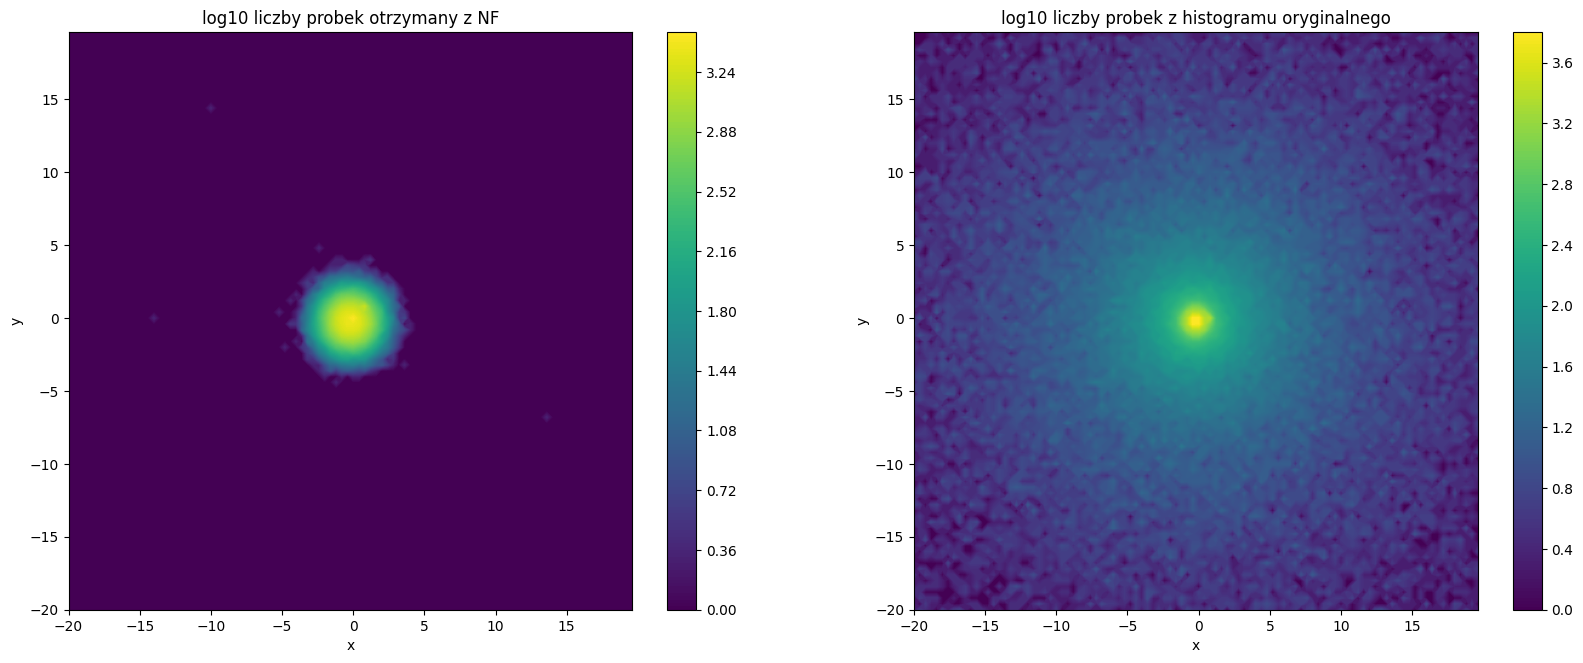

In [138]:
PROBE_SIZE = SAMPLES_TO_RETURN * BATCH_SIZE
normal_dist = torch.randn(size=(BATCH_SIZE, SAMPLES_TO_RETURN // 2, 2)).cuda()
theory, angles = get_shower_data_with_angle(PROBE_SIZE, BATCH_SIZE)

x_normal_dist, y_normal_dist = normal_dist[:, :, 0], normal_dist[:, :, 1]
x_normal_dist = torch.cat([x_normal_dist, angles.expand(BATCH_SIZE, 2)], dim=1)
y_normal_dist = torch.cat([y_normal_dist, angles.expand(BATCH_SIZE, 2)], dim=1)

x_nkg = x_model.inverse(x_normal_dist, angles).detach().cpu().numpy().reshape(-1)
y_nkg = y_model.inverse(y_normal_dist, angles).detach().cpu().numpy().reshape(-1)

x_theory, y_theory = theory[:, :, 0].flatten().cpu().numpy(), theory[:, :, 1].flatten().cpu().numpy()
original_hist, x_edges_orig, y_edges_orig = np.histogram2d(x_theory, y_theory, bins=100, range=[[-20, 20], [-20, 20]])

hist, x_edges, y_edges = np.histogram2d(x_nkg, y_nkg, bins=100, range=[[x_edges_orig[0], x_edges_orig[-1]], [y_edges_orig[0], y_edges_orig[-1]]])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7.5))

ax1.set_title('log10 liczby probek otrzymany z NF')
contour1 = ax1.contourf(x_edges[:-1], y_edges[:-1], np.log10(hist.T + 1), levels=200)
plt.colorbar(contour1, ax=ax1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_title('log10 liczby probek z histogramu oryginalnego')
contour2 = ax2.contourf(x_edges_orig[:-1], y_edges_orig[:-1], np.log10(original_hist.T + 1), levels=200)
plt.colorbar(contour2, ax=ax2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')

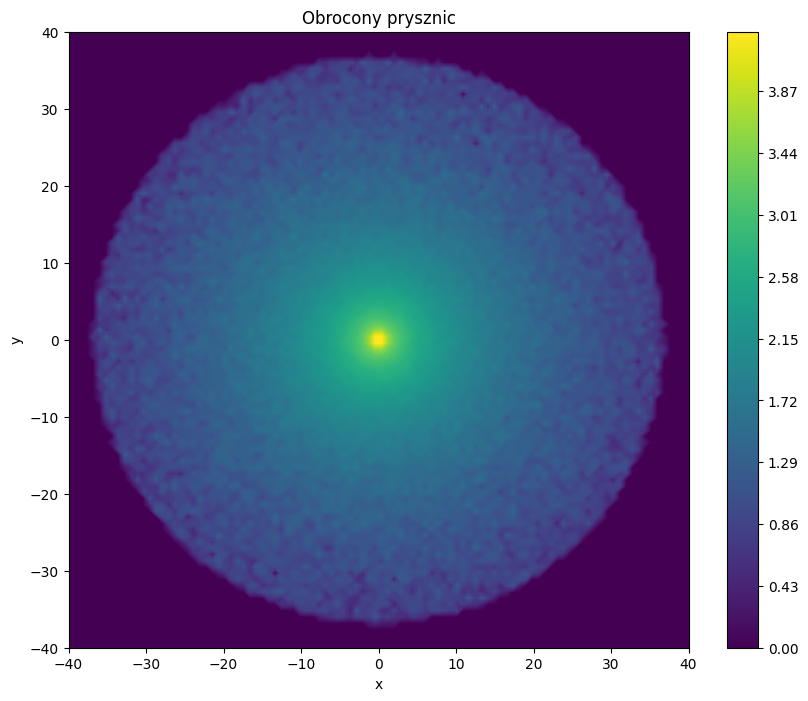

In [133]:
prober = rs_prober_NKG(epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0, theta=np.radians(30), alpha=np.radians(45), phi=0.0)
ret = get_2d_data(PROBE_SIZE=BATCH_SIZE*SAMPLES_TO_RETURN*2, prober=prober).reshape(-1, 2)
x, y = ret[:, 0], ret[:, 1]
histogram, x_bins, y_bins = np.histogram2d(x, y, bins=100, range=[
    [-40, 40], 
    [-40, 40]
])

plt.figure(figsize=(10, 8))
plt.title('Obrocony prysznic')
plt.contourf( np.log10(histogram + 1), extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], levels=1000 )
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()